In [1]:
import sys
sys.path.append('..\\..\\..')

In [2]:
from training.generators.FileImageGenerator import create_image_lists, get_generators

Using TensorFlow backend.


In [3]:
IMG_DIR = 'D:\\datasets\\Ms_Pacman\\Ms_Pacman\\Test\\'

In [4]:
#IMG_DIR = '..\..\..\\data\\atari_v1\\screens\\mspacman'
VAL_PCT = 25
VAL_FORMAT = 'png'

In [5]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in '0000'


  INFO     | 841 file found


  DEBUG    | Looking for images in '0001'


  INFO     | 1080 file found


  DEBUG    | Looking for images in '0002'


  INFO     | 624 file found


  DEBUG    | Looking for images in '0003'


  INFO     | 944 file found


  DEBUG    | Looking for images in '0004'


  INFO     | 1048 file found


  DEBUG    | Looking for images in '0005'


  INFO     | 938 file found


  DEBUG    | Looking for images in '0006'


  INFO     | 924 file found


  DEBUG    | Looking for images in '0007'


  INFO     | 651 file found


  DEBUG    | Looking for images in '0008'


  INFO     | 844 file found


  DEBUG    | Looking for images in '0009'


  INFO     | 698 file found


  DEBUG    | Looking for images in '0010'


  INFO     | 813 file found


  DEBUG    | Looking for images in '0011'


  INFO     | 938 file found


  DEBUG    | Looking for images in '0012'


  INFO     | 962 file found


  DEBUG    | Looking for images in '0013'


  INFO     | 950 file found


  DEBUG    | Looking for images in '0014'


  INFO     | 840 file found


  DEBUG    | Looking for images in '0015'


  INFO     | 858 file found


  DEBUG    | Looking for images in '0016'


  INFO     | 795 file found


  DEBUG    | Looking for images in '0017'


  INFO     | 915 file found


  DEBUG    | Looking for images in '0018'


  INFO     | 929 file found


  DEBUG    | Looking for images in '0019'


  INFO     | 1012 file found


  DEBUG    | Looking for images in '0020'


  INFO     | 995 file found


  DEBUG    | Looking for images in '0021'


  INFO     | 952 file found


  DEBUG    | Looking for images in '0022'


  INFO     | 1097 file found


  DEBUG    | Looking for images in '0023'


  INFO     | 1017 file found


  DEBUG    | Looking for images in '0024'


  INFO     | 787 file found


  DEBUG    | Looking for images in '0025'


  INFO     | 846 file found


  DEBUG    | Looking for images in '0026'


  INFO     | 669 file found


  DEBUG    | Looking for images in '0027'


  INFO     | 1085 file found


  DEBUG    | Looking for images in '0028'


  INFO     | 786 file found


  DEBUG    | Looking for images in '0029'


  INFO     | 841 file found


  DEBUG    | Looking for images in '0030'


  INFO     | 908 file found


  DEBUG    | Looking for images in '0031'


  INFO     | 1076 file found


  DEBUG    | Looking for images in '0032'


  INFO     | 1085 file found


  DEBUG    | Looking for images in '0033'


  INFO     | 849 file found


  DEBUG    | Looking for images in '0034'


  INFO     | 925 file found


  DEBUG    | Looking for images in '0035'


  INFO     | 1341 file found


  DEBUG    | Looking for images in '0036'


  INFO     | 1241 file found


  DEBUG    | Looking for images in '0037'


  INFO     | 1074 file found


  DEBUG    | Looking for images in '0038'


  INFO     | 858 file found


  DEBUG    | Looking for images in '0039'


  INFO     | 1032 file found


  DEBUG    | Looking for images in '0040'


  INFO     | 948 file found


  DEBUG    | Looking for images in '0041'


  INFO     | 977 file found


  DEBUG    | Looking for images in '0042'


  INFO     | 625 file found


  DEBUG    | Looking for images in '0043'


  INFO     | 768 file found


  DEBUG    | Looking for images in '0044'


  INFO     | 940 file found


  DEBUG    | Looking for images in '0045'


  INFO     | 890 file found


  DEBUG    | Looking for images in '0046'


  INFO     | 682 file found


  DEBUG    | Looking for images in '0047'


  INFO     | 976 file found


  DEBUG    | Looking for images in '0048'


  INFO     | 994 file found


  DEBUG    | Looking for images in '0049'


  INFO     | 863 file found


  DEBUG    | Looking for images in '0050'


  INFO     | 648 file found


In [6]:
IMG_SIZE=(160, 210, 3)
BATCH_SIZE = 5
EPIS_LEN = 10
EPIS_SHIFT = 5

In [7]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='episode', 
    episode_len=EPIS_LEN, 
    episode_shift=EPIS_SHIFT
)

  INFO     | Found 33971 training files


  INFO     | Found 12408 validation files


In [8]:
import tensorflow as tf

In [9]:
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen, 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE), 
                   tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE)
                  )
)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_gen,     
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE), 
                   tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE)
                  )
)


In [10]:
dataset_name = 'atari_v1'

In [11]:
intermediate_dim = 10
inputs_shape= (EPIS_LEN, )+IMG_SIZE # image shape
LATENT_DIM = 10

In [12]:
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

In [13]:
model_name = 'Atari_AE'

In [14]:
recoding_dir='..\\..\\..\\recoding\\'+model_name

In [15]:
import os
os.path.join(recoding_dir, model_name)

'..\\recoding\\Atari_AE\\Atari_AE'

In [16]:
from training.autoencoders.AE import AE

In [17]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':LATENT_DIM,
        'layers': enc_mean_lays
    }
    ,
    
        {
        'name': 'generative', 
        'inputs_shape':LATENT_DIM,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [18]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [19]:
_restore

'..\\recoding\\Atari_AE\\var_save_dir'

In [20]:
ae = AE( 
    model_name=model_name, 
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape, 
    latent_dim=LATENT_DIM, 
    variables_params=variables_params, 
    restore=None
    )

Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 160, 210, 10)  40        
_________________________________________________________________
dense_1 (Dense)              (None, 10, 160, 210, 10)  110       
_________________________________________________________________
dense_2 (Dense)              (None, 10, 160, 210, 10)  110       
_________________________________________________________________
flatten (Flatten)            (None, 3360000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                33600010  
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0 

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1008000)           21168000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1008000)           4032000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1008000)           0

  WARNING  | None


In [21]:
import numpy as np
n_generated = 36
#random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
#random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))

In [22]:
random_latent = tf.constant(np.random.normal(size=[n_generated, LATENT_DIM]))
random_latent.shape

TensorShape([36, 10])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



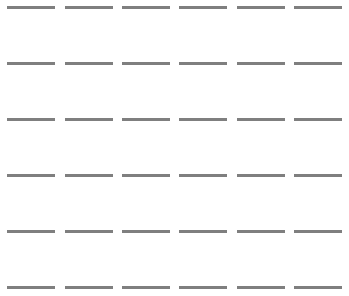

  ERROR    | No former training found ... 
Epochs Progress:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

  INFO     | Training ... 
Epochs Progress, Training Iterations 4:   0%|                                                   | 0/10 [00:13<?, ?it/s]

KeyboardInterrupt: 

In [23]:
ae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_names=['episode'],
    epochs=10,
    learning_rate=1e-3,
    random_latent=random_latent,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5
)